5. (25 points) For the final part of this assignment you can choose to use
random forests or AdaBoost. If you are curious about the differences, feel
free to compare both methods, but this is not required for the assignment.
For your method of choice, find out what widely used implementations are
available in your favourite programming language and apply the method
to a prediction problem you find interesting (see, for instance, the UCI
Machine Learning repository for interesting datasets).
Write a short summary of your findings. Describe which dataset and
implementation you used, how you set up your experiment, and discuss
your results.
Things to keep in mind:
• Include a simple baseline: a classifier without an ensemble, and compare this with the ensemble model.
• What is the effect of different parameter settings? (Such as the size
of the ensemble, the depth of the trees etc.) Include plots to show
the performance for different values, and choose ranges that show all
the interesting points.
• If your ensemble method includes a feature selection component, discuss which features are selected.
• Set up a proper machine learning experiment (no training on the test
set etc.) to get reliable results.
Please also upload the code for your experiments, but make sure we can
understand your summary without it: include all the necessary details
and results in the text

a) Choosing and importing a dataset

In [15]:
# Initial imports
import numpy as np
import pandas as pd
from os import path, getcwd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


We have chosen to use the "Motion Capture Hand Postures Data Set", provided through the UCI Machine Learning platform under http://archive.ics.uci.edu/ml/datasets/Motion+Capture+Hand+Postures

In [2]:
# Importing the data from the file
data_path = path.join(getcwd(), 'Postures', 'Postures.csv')
df = pd.read_csv(data_path, dtype='str')

First, we perform some preliminary exploratory analysis of the dataset

In [3]:
df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,54.2638799540698,71.4667761378817,-64.807708780882,76.8956347751343,42.462499897063,-72.7805451867589,36.6212291601289,81.6805569287795,...,?,?,?,?,?,?,?,?,?,?
2,1,0,56.5275584513992,72.2666086344311,-61.9352524181086,39.1359781094435,82.5385299123923,-49.596509402198,79.2237427757379,43.2540908549394,...,?,?,?,?,?,?,?,?,?,?
3,1,0,55.8499275533856,72.4690639900078,-62.5627881992281,37.9888039795987,82.6313466902829,-50.6062592522547,78.4515264181117,43.5674025538352,...,?,?,?,?,?,?,?,?,?,?
4,1,0,55.3296473571984,71.7072747279931,-63.6889560555559,36.5618625820934,81.8687487820502,-52.7527843041592,86.3206299370292,68.2146450062245,...,?,?,?,?,?,?,?,?,?,?


Inspecting the head of the dataset reveals, that we have a label/classification column called 'Class'. According to the provided description of the dataset, the labels can be $\in \{1,\dots,5\}$. Further, there is a column 'User', which provides the ID of the user from which the recording is taken. According to the description of the set, this does not have any influence on possible classifications, i.e. it can safely be removed throughout the pre-processing of the data.
Finally, there are 36 different indicators that can be used for inference of the class.

We remove the redundant column from the set:

In [4]:
df = df.drop(columns=['User'])

df.head()

,Class,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,54.2638799540698,71.4667761378817,-64.807708780882,76.8956347751343,42.462499897063,-72.7805451867589,36.6212291601289,81.6805569287795,-52.9192723726971,...,?,?,?,?,?,?,?,?,?,?
2,1,56.5275584513992,72.2666086344311,-61.9352524181086,39.1359781094435,82.5385299123923,-49.596509402198,79.2237427757379,43.2540908549394,-69.982489053646,...,?,?,?,?,?,?,?,?,?,?
3,1,55.8499275533856,72.4690639900078,-62.5627881992281,37.9888039795987,82.6313466902829,-50.6062592522547,78.4515264181117,43.5674025538352,-70.6584892573659,...,?,?,?,?,?,?,?,?,?,?
4,1,55.3296473571984,71.7072747279931,-63.6889560555559,36.5618625820934,81.8687487820502,-52.7527843041592,86.3206299370292,68.2146450062245,-72.2284608701467,...,?,?,?,?,?,?,?,?,?,?


To ensure that there are no faulty labels in the labels (in the sense of being outside of the possible space), we check that all datapoints correspond to a valid label.

In [5]:
valid_labels = np.array(['1','2','3','4','5'])

try: 
  assert set(df['Class']) == set(valid_labels)
except AssertionError:
  faulty_entries = df.index[[value not in valid_labels for value in df['Class']]].to_list()
  print(f'found following faulty datapoints: {faulty_entries}')
  print(f'removing the faulty entries from the set...')
  df = df.drop(faulty_entries)

found following faulty datapoints: [0]
removing the faulty entries from the set...


Next, we have to ensure that there are no faulty values provided for features. To check this, we convert all feature entries to floats and remove datapoints that are non-convertible (i.e they contain non-numeric characters).

In [6]:
def check_numeric(x):
    try:
        float(x)
        return True
    except:
        return False

for column in df:
  if column == 'Class':
    pass
  else:
    num_faulty_entries = len(df.index[~df[column].apply(check_numeric)].to_list())
    if len(faulty_entries) > 0:
      print(f'found {num_faulty_entries} faulty datapoints in column: {column}')

found 0 faulty datapoints in column: X0
found 0 faulty datapoints in column: Y0
found 0 faulty datapoints in column: Z0
found 0 faulty datapoints in column: X1
found 0 faulty datapoints in column: Y1
found 0 faulty datapoints in column: Z1
found 0 faulty datapoints in column: X2
found 0 faulty datapoints in column: Y2
found 0 faulty datapoints in column: Z2
found 690 faulty datapoints in column: X3
found 690 faulty datapoints in column: Y3
found 690 faulty datapoints in column: Z3
found 3120 faulty datapoints in column: X4
found 3120 faulty datapoints in column: Y4
found 3120 faulty datapoints in column: Z4
found 13023 faulty datapoints in column: X5
found 13023 faulty datapoints in column: Y5
found 13023 faulty datapoints in column: Z5
found 25848 faulty datapoints in column: X6
found 25848 faulty datapoints in column: Y6
found 25848 faulty datapoints in column: Z6
found 39152 faulty datapoints in column: X7
found 39152 faulty datapoints in column: Y7
found 39152 faulty datapoints in 

The analysis of the different feature vectors shows, that the amount of faulty datapoints per feature is progressively increasing. While (X0,Y0,Z0) have no faulty datapoints, (X3,Y3,Z3) are showing 690 faulty values and at the end of the spectrum (X11,Y11,Z11) only have 31 entries that are not faulty. Thus, a decision is to be made on how to properly handle the faulty entries. First, we decide to drop all features X,Y,Z > 4, as (X5,Y,Z5) is where the amount of faulty entries is drastically increasing from 3120 -> 13023. 

For the remaining features, we have decided to keep the datapoints with faulty/missing values, and simply replace these values with a standard value of 0.

In [7]:
# Drop the columns that are not going to be used
df = df.drop(columns=['X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6', 'X7', 'Y7', 'Z7', 'X8', 'Y8', 'Z8', 'X9', 'Y9', 'Z9', 'X10', 'Y10', 'Z10', 'X11', 'Y11', 'Z11'])

df.head()

,Class,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,X4,Y4,Z4
1,1,54.2638799540698,71.4667761378817,-64.807708780882,76.8956347751343,42.462499897063,-72.7805451867589,36.6212291601289,81.6805569287795,-52.9192723726971,85.2322638852917,67.7492195028673,-73.684130041833,59.1885757027887,10.6789364098231,-71.2977813147725
2,1,56.5275584513992,72.2666086344311,-61.9352524181086,39.1359781094435,82.5385299123923,-49.596509402198,79.2237427757379,43.2540908549394,-69.982489053646,87.4508729469625,68.4008083028339,-70.703990925959,61.5874515532753,11.7799190329758,-68.827417756239
3,1,55.8499275533856,72.4690639900078,-62.5627881992281,37.9888039795987,82.6313466902829,-50.6062592522547,78.4515264181117,43.5674025538352,-70.6584892573659,86.8353875680762,68.9079249764243,-71.1383441365739,61.6864271910576,11.7934398850428,-68.88931646056
4,1,55.3296473571984,71.7072747279931,-63.6889560555559,36.5618625820934,81.8687487820502,-52.7527843041592,86.3206299370292,68.2146450062245,-72.2284608701467,61.5961571288978,11.2506481750465,-68.9564252307431,77.3872254123912,42.7178334810919,-72.0151462991019
5,1,55.1424005703039,71.4356074614863,-64.1773032137746,36.175817734146,81.5568735764025,-53.4757466141485,76.9861434825171,42.4268485214705,-72.574743056517,86.3687480605765,67.9012603746826,-72.4446499648169,61.2754021959714,10.8411094568665,-69.2799064015993


In [8]:
# Replace faulty entries in the remaining features
for column in df:
  if column == 'Class':
    pass
  else:
    df[column][~df[column].apply(check_numeric)] = 0

In [9]:
# Check if any faulty entries remain
for column in df:
  if column == 'Class':
    pass
  else:
    num_faulty_entries = len(df.index[~df[column].apply(check_numeric)].to_list())
    if len(faulty_entries) > 0:
      print(f'found {num_faulty_entries} faulty datapoints in column: {column}')

found 0 faulty datapoints in column: X0
found 0 faulty datapoints in column: Y0
found 0 faulty datapoints in column: Z0
found 0 faulty datapoints in column: X1
found 0 faulty datapoints in column: Y1
found 0 faulty datapoints in column: Z1
found 0 faulty datapoints in column: X2
found 0 faulty datapoints in column: Y2
found 0 faulty datapoints in column: Z2
found 0 faulty datapoints in column: X3
found 0 faulty datapoints in column: Y3
found 0 faulty datapoints in column: Z3
found 0 faulty datapoints in column: X4
found 0 faulty datapoints in column: Y4
found 0 faulty datapoints in column: Z4


After this preliminary cleaning of the set, we explore the range of values of the features.

In [10]:
X = df.drop(columns=['Class'])
Y = df['Class']

X = X.astype('float')

for column in X:
  print(f'Column: {column}, Max: {X[column].astype(float).max(axis=0)}, Min: {X[column].min()} Average: {X[column].mean()}')

Column: X0, Max: 190.017835268349, Min: -108.552738453534 Average: 50.34630849916872
Column: Y0, Max: 169.175463674415, Min: -98.2337564254493 Average: 85.81314953888146
Column: Z0, Max: 113.345118737492, Min: -126.770871922379 Average: -29.985095790392123
Column: X1, Max: 188.691996610615, Min: -111.685241228502 Average: 49.59584391541871
Column: Y1, Max: 170.20935042246, Min: -96.1425893862385 Average: 86.1937508857489
Column: Z1, Max: 104.697852278568, Min: -166.006838330746 Average: -29.50957947801039
Column: X2, Max: 188.760167660165, Min: -106.88652434261 Average: 48.61274363683823
Column: Y2, Max: 168.186466480241, Min: -100.789312248425 Average: 83.77238734187073
Column: Z2, Max: 104.590878975593, Min: -129.595295926856 Average: -30.56090626855148
Column: X3, Max: 151.033472021347, Min: -111.761052901312 Average: 48.064122991010194
Column: Y3, Max: 168.292018313066, Min: -97.6034138799701 Average: 81.33925334320821
Column: Z3, Max: 129.316869607955, Min: -143.540528780696 Avera

Before proceeding with training the classifier, we want to replace the placeholder values we have provided for the faulty entries with the class-specific mean of the feature.

In [11]:
for column in X:
  for label in valid_labels:
    # Replace the placeholders with the class-specific mean
    X[column][X[column] == 0] = (X[column][Y == label]).mean()

In [12]:
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X0,78095.0,50.346308,32.695886,-108.552738,29.295141,54.620245,72.488833,190.017835
Y0,78095.0,85.813150,40.203448,-98.233756,63.497746,86.526334,113.108673,169.175464
Z0,78095.0,-29.985096,34.361971,-126.770872,-56.356593,-30.864248,-1.419462,113.345119
X1,78095.0,49.595844,32.477961,-111.685241,28.755679,54.215714,71.763080,188.691997
Y1,78095.0,86.193751,40.452297,-96.142589,64.156450,87.543493,116.228881,170.209350
Z1,78095.0,-29.509579,34.764460,-166.006838,-57.360408,-30.185331,-0.368080,104.697852
X2,78095.0,48.612744,33.605155,-106.886524,25.173405,53.814592,71.561988,188.760168
Y2,78095.0,83.772387,41.022710,-100.789312,58.053733,86.459935,106.661720,168.186466
Z2,78095.0,-30.560906,35.120384,-129.595296,-58.654339,-32.356535,-0.946134,104.590879
X3,78095.0,48.434359,33.728778,-111.761053,24.183508,53.888390,71.216793,151.033472


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

0.6285799650006403


C:\Users\jsche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


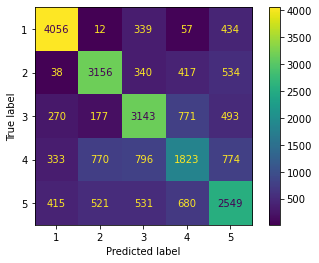

In [19]:
lg_classifier = LogisticRegression(max_iter=500)

lg_classifier.fit(X_train, y_train)

print(lg_classifier.score(X_test, y_test))

plot_confusion_matrix(lg_classifier, X_test, y_test) 

0.6286226471466986


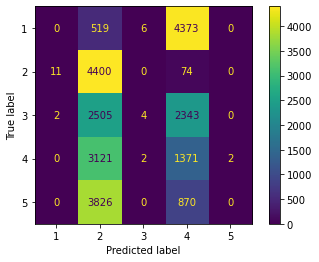

In [18]:
scaler = StandardScaler().fit(X_train)

X_scaled = scaler.transform(X_train)

lg_classifier = LogisticRegression(max_iter=1000)
lg_classifier.fit(X_scaled, y_train)

X_test_scaled = scaler.transform(X_test)
print(lg_classifier.score(X_test_scaled, y_test))
plot_confusion_matrix(lg_classifier, X_test, y_test)

0.7008835204234068


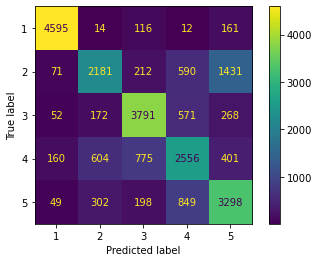

In [20]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)

clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))
plot_confusion_matrix(clf, X_test, y_test)

0.8284177728456187


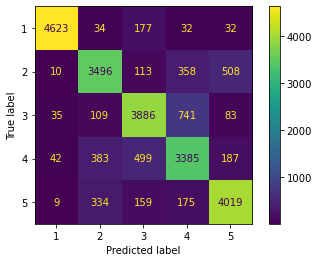

In [21]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=300, learning_rate=1.5, random_state=0, algorithm='SAMME')

clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))
plot_confusion_matrix(clf, X_test, y_test)

0.7369926159887319


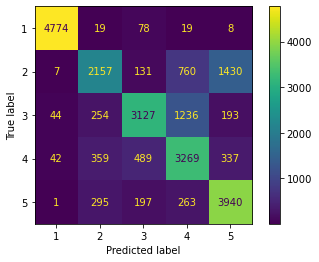

In [22]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=300, learning_rate=1.5, random_state=0)

clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))
plot_confusion_matrix(clf, X_test, y_test)

In [21]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=300, learning_rate=1, random_state=0, algorithm='SAMME')

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.8280763156771522

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      4898
           2       0.96      0.96      0.96      4485
           3       0.96      0.98      0.97      4854
           4       0.98      0.95      0.96      4496
           5       0.98      0.98      0.98      4696

    accuracy                           0.98     23429
   macro avg       0.97      0.97      0.97     23429
weighted avg       0.98      0.98      0.98     23429



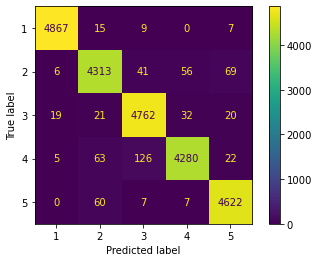

In [23]:
rtree = RandomForestClassifier(100)
rtree.fit(X_train, y_train)
prediction = rtree.predict(X_test)
print(classification_report(y_test,prediction))
plot_confusion_matrix(rtree, X_test, y_test)

In [34]:
rtree.score(X_test, y_test)

0.9747321695334842

In [33]:
rtree = RandomForestClassifier(50)
rtree.fit(X_train, y_train)
prediction = rtree.predict(X_test)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      4898
           2       0.96      0.96      0.96      4485
           3       0.96      0.98      0.97      4854
           4       0.98      0.95      0.96      4496
           5       0.97      0.98      0.98      4696

    accuracy                           0.97     23429
   macro avg       0.97      0.97      0.97     23429
weighted avg       0.97      0.97      0.97     23429



In [34]:
rtree.score(X_test, y_test)

0.9734090230056768